In [257]:
import numpy as np
import sympy as sp
import random
from typing import Callable, Tuple
import matplotlib.pyplot as plt

# Простий градієнтний спуск

Перед застосуванням градієнтного спуску оголосимо функцію $E$ та її градієнт

In [258]:
w1, w2 = sp.symbols('w1 w2')
sigma, a, b = sp.symbols('sigma a b')
R11, R12, R21, R22 = sp.symbols('R11 R12 R21 R22')

R = sp.Matrix([[R11, R12], [R21, R22]])
w_vec = sp.Matrix([w1, w2])
quadratic_form = (w_vec.T * R * w_vec)[0, 0]

E_expr = 1/2 * sigma ** 2 - (a * w1 + b * w2) + 1/2 * quadratic_form
derivative_w1 = sp.diff(E_expr, w1)
derivative_w2 = sp.diff(E_expr, w2)

gradE = sp.lambdify((w1, w2, sigma, a, b, R11, R12, R21, R22), [derivative_w1, derivative_w2], 'numpy')

In [259]:
sigma = np.random.rand(); a = 0.9; b = 0.2; c = 0.6; R = np.matrix([[1, c], [c, 1]]); eta = 0.4; precision = 1e-3

E = lambda w: 1 / 2 * sigma ** 2 - np.array([a,b]) @ w + 1 / 2 * np.transpose(w) @ R @ w
print(f'E = 1 / 2 * {sigma} ** 2 - {np.array([a, b])} * w + 1 / 2 * wT * {R} * w')

E = 1 / 2 * 0.21949393682222518 ** 2 - [0.9 0.2] * w + 1 / 2 * wT * [[1.  0.6]
 [0.6 1. ]] * w


Тепер можна запускати алгоритм градієнтного спуску. Умова зупинки - $\|w(k) - w(k+1)\|<0.001$

In [260]:
def gradient_descent(
        E: Callable[[np.ndarray], np.ndarray],
        gradE: Callable[[float, float, float, float, float, float, float, float, float], Tuple[float, float]],
        precision: float,
        eta: float,
        maxsteps=500
    ) -> (np.ndarray, bool):
    i = 0 # Номер ітерації
    w_i = [] # Список точок для побудови траекторій
    w = np.array([random.uniform(-10, 10), random.uniform(-10, 10)]) # Обираємо початкову точку випадково
    print(f'starting target function value = {E(w)}\n')
    eps = 1 # Змінна, що відслідковує норму різниці w(k) і w(k-1)

    while eps >= precision:
        if i >= maxsteps: # Якщо досягнено заданої кількості кроків - зупинити виконання передчасно
            return w_i
        i += 1
        print(f'iteration = {i}')
        grad = gradE(*w, sigma, a, b, R[0, 0], R[0, 1], R[1, 0], R[1, 1]) # Обчислення градієнту в поточній точці
        print(f'gradient of E in {w} = {grad}')
        w_new = w - eta * np.array(grad) # Оновлення точки
        print(f'updated w:  w = {w_new}')
        eps = np.linalg.norm(w - w_new)
        print(f'E(w) = {E(w_new)}')
        print(f'eps = {eps}\n')
        w = w_new

        w_i.append(w) # Додаємо стару точку до списку

    return w_i


descent_trajectory = gradient_descent(E, gradE, precision, eta)

starting target function value = [[38.01646367]]

iteration = 1
gradient of E in [-0.06104981 -8.47698743] = [np.float64(-6.0472422690147445), np.float64(-8.713617315264026)]
updated w:  w = [ 2.3578471 -4.9915405]
E(w) = [[7.0762207]]
eps = 4.242570273351335

iteration = 2
gradient of E in [ 2.3578471 -4.9915405] = [np.float64(-1.5370772057454798), np.float64(-3.7768322445948774)]
updated w:  w = [ 2.97267798 -3.4808076 ]
E(w) = [[2.31286604]]
eps = 1.6310520845262502

iteration = 3
gradient of E in [ 2.97267798 -3.4808076 ] = [np.float64(-0.01580658474451735), np.float64(-1.8972008173780108)]
updated w:  w = [ 2.97900061 -2.72192728]
E(w) = [[1.16386626]]
eps = 0.7589066650998478

iteration = 4
gradient of E in [ 2.97900061 -2.72192728] = [np.float64(0.445844245324012), np.float64(-1.1345269100881223)]
updated w:  w = [ 2.80066291 -2.26811651]
E(w) = [[0.63981023]]
eps = 0.4875946514559225

iteration = 5
gradient of E in [ 2.80066291 -2.26811651] = [np.float64(0.5397930056155572), np

Алгоритм збігся, не досягши максимальної кількості ітерацій.

Створюємо функцію для зображення траекторій вектору w протягом роботи алгоритму

In [261]:
def plot_descent(w_i: np.ndarray, f: Callable[[np.ndarray], np.ndarray], descent_name: str) -> None:
    x_i = np.array([w[0] for w in w_i])
    y_i = np.array([w[1] for w in w_i])
    z_i = np.array([f(w).item() for w in w_i])

    fig = plt.figure(figsize=(14, 8))
    fig.suptitle(descent_name)

    ax = fig.add_subplot(2, 1, 1)

    ax.plot(x_i, y_i)
    ax.scatter(x_i[0], y_i[0], color='green', s=20, label='Початок')
    if len(z_i) < 500:
        ax.scatter(x_i[-1], y_i[-1], color='red', s=20, label='Мінімум')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Trajectory of w(t) in W')
    ax.legend()
    ax.grid(True)
    ax.axis('equal')

    ax = fig.add_subplot(2, 1, 2, projection='3d')

    # Адаптивні межі графіку
    margin = abs(x_i.min() - x_i.max()) * 0.1
    x_min, x_max = x_i.min() - margin, x_i.max() + margin
    margin = abs(y_i.min() - y_i.max()) * 0.1
    y_min, y_max = y_i.min() - margin, y_i.max() + margin

    x_vals = np.linspace(x_min, x_max, 50)
    y_vals = np.linspace(y_min, y_max, 50)
    X, Y = np.meshgrid(x_vals, y_vals)

    X_flat = X.flatten()
    Y_flat = Y.flatten()
    points = np.column_stack((X_flat, Y_flat))
    Z_flat = np.array([f(point) for point in points])

    Z = Z_flat.reshape(X.shape)

    z_min, z_max = Z.min(), Z.max()
    z_range = z_max - z_min
    ax.set_zlim(z_min - 0.005 * z_range, z_max + 0.005 * z_range)

    surf = ax.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis', linewidth=0)

    ax.plot(x_i, y_i, z_i, 'r-', linewidth=3, markersize=4, label='Траєкторія')
    ax.scatter(x_i[0], y_i[0], z_i[0], color='green', s=20, label='Початок')
    if len(z_i) < 500:
        ax.scatter(x_i[-1], y_i[-1], z_i[-1], color='red', s=20, label='Мінімум')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('E')
    ax.set_title('Trajectory of w(t) in 3D space')
    ax.legend(loc='upper right')

    plt.show()

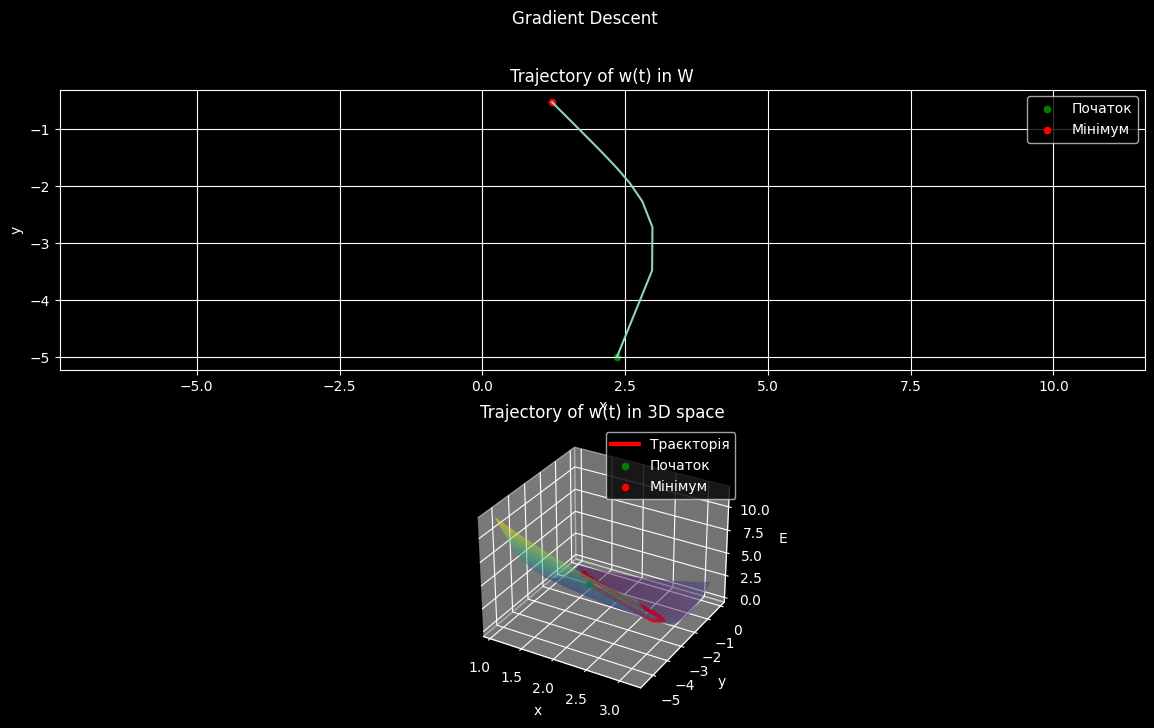

In [262]:
plot_descent(descent_trajectory, E, 'Gradient Descent')

Знайдемо точне значення $w^*$ за допомогою нормального рівняння $w^*=R^{-1}p$

In [263]:
rho = np.array([a,b])
R_I = np.linalg.inv(R)

w_opt = R_I @ rho
w_opt

matrix([[ 1.21875, -0.53125]])

Порівняємо зі знайденим за допомогою градієнтного спуску мінімумом

In [264]:
print(f'Чисельно знайдена точка мінімуму: {descent_trajectory[-1]}')
print(f'Вектор різниці між точкою w* і знайденою точкою мінімуму: {w_opt - descent_trajectory[-1]}')
print(f'Норма вектора різниці: {np.linalg.norm(w_opt - descent_trajectory[-1])}')

Чисельно знайдена точка мінімуму: [ 1.22186891 -0.53436891]
Вектор різниці між точкою w* і знайденою точкою мінімуму: [[-0.00311891  0.00311891]]
Норма вектора різниці: 0.004410803287185345


Обчислимо власні числа матриці автокореляцій R

In [265]:
lambdas = np.linalg.eigvals(R)
lambda_max = max(lambdas)
lambda_min = min(lambdas)

In [266]:
print(f'Алгоритм має збігатися при 0 < eta < {2 / lambda_max}')

Алгоритм має збігатися при 0 < eta < 1.25


In [267]:
eta = 2/lambda_max*0.95
conv_desc = gradient_descent(E, gradE, precision, eta)

starting target function value = [[25.49256364]]

iteration = 1
gradient of E in [-0.80248014  7.70380516] = [np.float64(2.919802957464101), np.float64(7.022317073954109)]
updated w:  w = [-4.26974615 -0.63519637]
E(w) = [[14.93827925]]
eps = 9.031106246589571

iteration = 2
gradient of E in [-4.26974615 -0.63519637] = [np.float64(-5.550863969716822), np.float64(-3.3970440585595685)]
updated w:  w = [2.32190482 3.39879345]
E(w) = [[10.46114014]]
eps = 7.728061613099425

iteration = 3
gradient of E in [2.32190482 3.39879345] = [np.float64(3.461180886045597), np.float64(4.591936339403155)]
updated w:  w = [-1.78824749 -2.05413095]
E(w) = [[7.95695595]]
eps = 6.82845051914351

iteration = 4
gradient of E in [-1.78824749 -2.05413095] = [np.float64(-3.9207260579582974), np.float64(-3.3270794449455794)]
updated w:  w = [2.86761471 1.89677589]
E(w) = [[6.23790028]]
eps = 6.106285092685198

iteration = 5
gradient of E in [2.86761471 1.89677589] = [np.float64(3.1056802403909054), np.float64(3.4

In [268]:
print('eta:', eta)
print(f'Норма відстані до w*: {np.linalg.norm(conv_desc[-1] - w_opt)}')

eta: 1.1875
Норма відстані до w*: 0.0004591370534904648


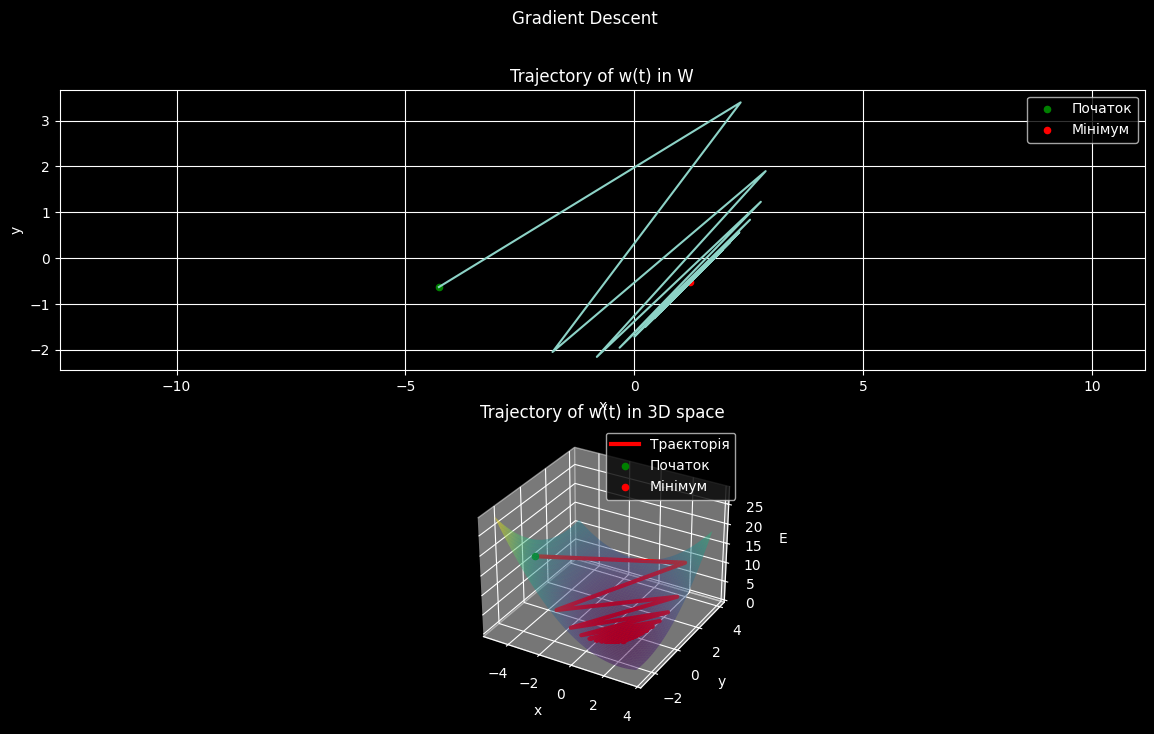

In [269]:
plot_descent(conv_desc, E, 'Gradient Descent')

Отже, при $\eta < 1.25$ алгоритм градієнтного спуску дійсно збігається

In [270]:
eta = 2/lambda_max/0.95
div_desc = gradient_descent(E, gradE, precision, eta)
print('\n')

starting target function value = [[28.89406472]]

iteration = 1
gradient of E in [-4.73871907 -2.95810647] = [np.float64(-7.41358294980342), np.float64(-6.001337913405819)]
updated w:  w = [5.01599534 4.93839078]
E(w) = [[34.15853831]]
eps = 12.550263824500833

iteration = 2
gradient of E in [5.01599534 4.93839078] = [np.float64(7.079029810521464), np.float64(7.747987985657169)]
updated w:  w = [-4.29851757 -5.25633025]
E(w) = [[41.55380791]]
eps = 13.809145074199806

iteration = 3
gradient of E in [-4.29851757 -5.25633025] = [np.float64(-8.35231571831507), np.float64(-8.035440793250789)]
updated w:  w = [6.69137154 5.31661816]
E(w) = [[50.80425208]]
eps = 15.25007870877081

iteration = 4
gradient of E in [6.69137154 5.31661816] = [np.float64(8.98134243203433), np.float64(9.131441080748992)]
updated w:  w = [-5.12618429 -6.69843589]
E(w) = [[62.1531964]]
eps = 16.852778695066693

iteration = 5
gradient of E in [-5.12618429 -6.69843589] = [np.float64(-10.045245831760047), np.float64(-9.

In [271]:
print('eta:', eta)
print(f'Норма відстані до w*: {np.linalg.norm(div_desc[-1] - w_opt)}')

eta: 1.3157894736842106
Норма відстані до w*: 3.204793308064829e+22


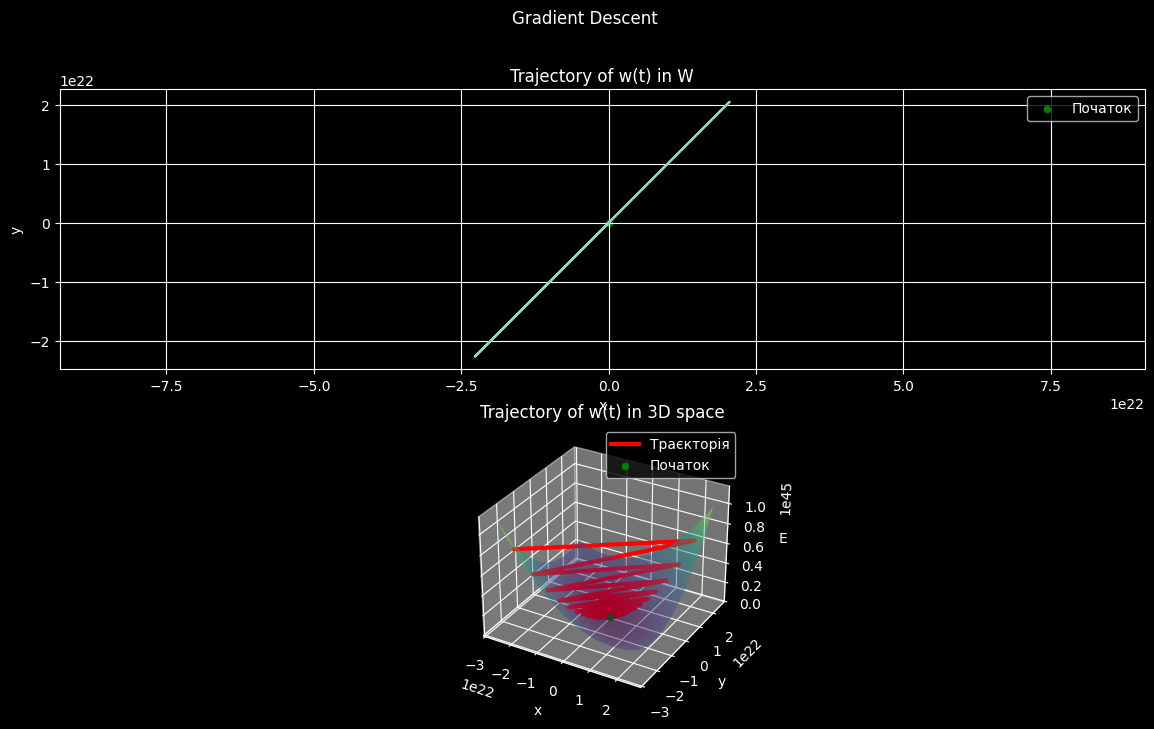

In [272]:
plot_descent(div_desc, E, 'Gradient Descent')

При $\eta > 1.25$ алгоритм градієнтного спуску розбігається

Оцінимо швидкість збіжності. Для цього знайдемо частку $\frac{\lambda_{min}}{\lambda_{max}}$, де $\lambda_{max}$ - максимальне власне число матриці $R$, а $\lambda_{min}$ - мінімальне.

In [273]:
print(lambda_min/lambda_max)

0.25000000000000006


Отримали значення ближче до нуля, що означає помірно повільну збіжність алгоритму.

# Adam Gradient Descent

In [274]:
def adam_gradient_descent(
        E: Callable[[np.ndarray], np.ndarray],
        gradE: Callable[[float, float, float, float, float, float, float, float, float], Tuple[float, float]],
        precision: float,
        eta: float,
        beta1=0.9,
        beta2=0.999,
        eps=1e-8,
        maxsteps=500
    ) -> (np.ndarray, bool):
    i = 0 # Номер ітерації
    w_i = [] # Список точок для побудови траекторій
    w = np.array([random.uniform(-10, 10), random.uniform(-10, 10)]) # Обираємо початкову точку випадково
    print(f'starting target function value = {E(w)}\n')
    eps = 1 # Змінна, що відслідковує норму різниці w(k) і w(k-1)
    m = np.zeros_like(w); v = np.zeros_like(w)


    while eps >= precision:
        if i >= maxsteps: # Якщо досягнено заданої кількості кроків - зупинити виконання передчасно
            return w_i
        i += 1
        print(f'iteration = {i}')
        g = np.array(gradE(*w, sigma, a, b, R[0, 0], R[0, 1], R[1, 0], R[1, 1])) # Обчислення градієнту в поточній точці
        print(f'gradient in {w} = {g}')
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2
        mt = m / (1 - beta1**i)
        vt = v / (1 - beta2**i)
        delta_w = - (eta * mt) / (np.sqrt(vt + eps))
        print(f'delta w = {delta_w}')
        w_new = w + delta_w # Оновлення точки
        print(f'updated w:  w = {w_new}')
        eps = np.linalg.norm(E(w) - E(w_new)) # Для Adam застосовуємо критерій зупинки за стабілізацією значення функції
        print(f'E(w) = {E(w_new)}')
        print(f'eps = {eps}\n')
        w = w_new

        w_i.append(w) # Додаємо стару точку до списку

    return w_i


descent_trajectory = adam_gradient_descent(E, gradE, precision, eta)

starting target function value = [[32.50704833]]

iteration = 1
gradient in [-2.06580958 -6.24504494] = [-6.71283654 -7.68453068]
delta w = [1.30142835 1.30478807]
updated w:  w = [-0.76438123 -4.94025687]
E(w) = [[16.46103536]]
eps = 16.046012968369144

iteration = 2
gradient in [-0.76438123 -4.94025687] = [-4.62853535 -5.59888561]
delta w = [1.05257458 1.1075131 ]
updated w:  w = [ 0.28819335 -3.83274376]
E(w) = [[7.25501086]]
eps = 9.206024497025723

iteration = 3
gradient in [ 0.28819335 -3.83274376] = [-2.91145291 -3.85982775]
delta w = [1.03929349 1.10333631]
updated w:  w = [ 1.32748684 -2.72940746]
E(w) = [[1.80722383]]
eps = 5.447787032421175

iteration = 4
gradient in [ 1.32748684 -2.72940746] = [-1.21015763 -2.13291535]
delta w = [0.96344632 1.05039695]
updated w:  w = [ 2.29093317 -1.6790105 ]
E(w) = [[0.02387606]]
eps = 1.7833477697881173

iteration = 5
gradient in [ 2.29093317 -1.6790105 ] = [ 0.38352687 -0.5044506 ]
delta w = [0.84304791 0.96696437]
updated w:  w = [ 3.1

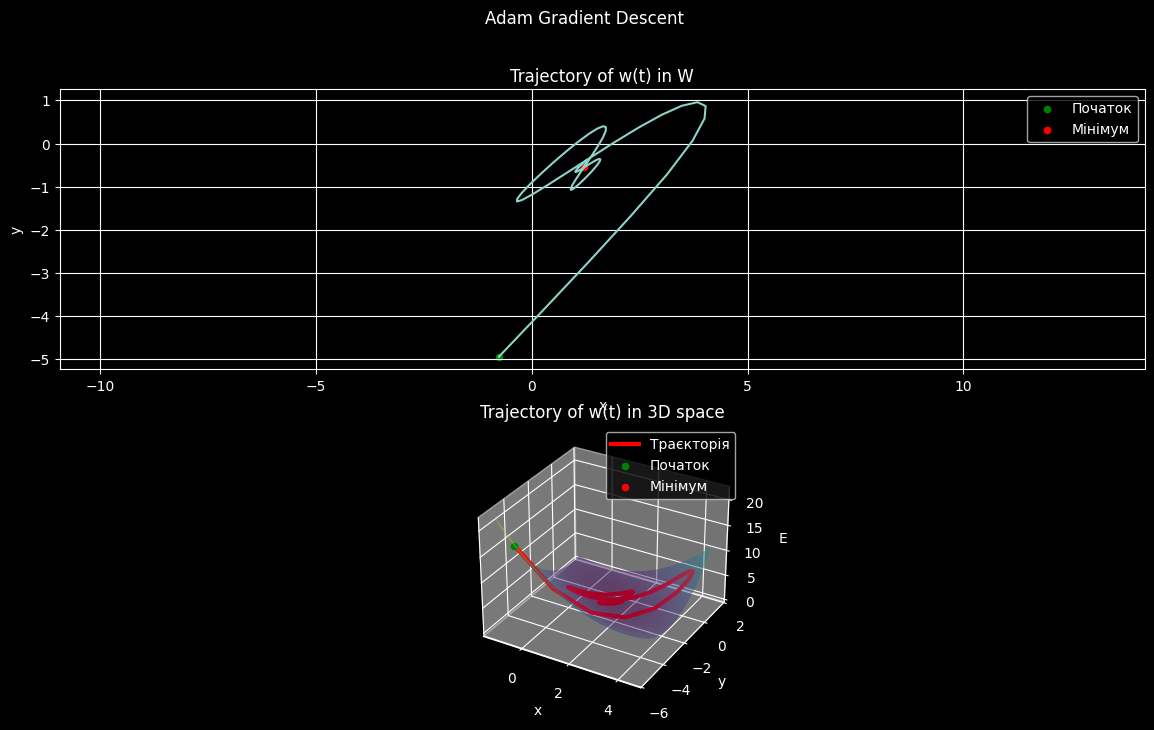

In [275]:
plot_descent(descent_trajectory, E, 'Adam Gradient Descent')

Спробуємо підібрати таке значення кроку, щоб алгоритм розбігався

In [276]:
eta = 1e12
div_desc = adam_gradient_descent(E, gradE, precision, eta)

starting target function value = [[102.32700203]]

iteration = 1
gradient in [-6.27111537 -9.06398338] = [-12.6095054  -13.02665261]
delta w = [9.96870095e+11 9.97066473e+11]
updated w:  w = [9.96870095e+11 9.97066473e+11]
E(w) = [[1.59031322e+24]]
eps = 1.5903132185085773e+24

iteration = 2
gradient in [9.96870095e+11 9.97066473e+11] = [1.59510998e+12 1.59518853e+12]
delta w = [-4.96153346e+11 -4.96166917e+11]
updated w:  w = [5.00716749e+11 5.00899557e+11]
E(w) = [[4.01294093e+23]]
eps = 1.1890191257895098e+24

iteration = 3
gradient in [5.00716749e+11 5.00899557e+11] = [8.01256483e+11 8.01329606e+11]
delta w = [-5.50105442e+11 -5.50125829e+11]
updated w:  w = [-4.93886935e+10 -4.92262719e+10]
E(w) = [[3.88996719e+21]]
eps = 3.9740412552681296e+23

iteration = 4
gradient in [-4.93886935e+10 -4.92262719e+10] = [-7.89244566e+10 -7.88594879e+10]
delta w = [-5.14442556e+11 -5.14475030e+11]
updated w:  w = [-5.63831250e+11 -5.63701302e+11]
E(w) = [[5.08531864e+23]]
eps = 5.046418967566066

In [279]:
print('eta:', eta)
print(f'Норма відстані до w*: {np.linalg.norm(div_desc[-1] - w_opt)}')

eta: 1000000000000.0
Норма відстані до w*: 1.230673143953906


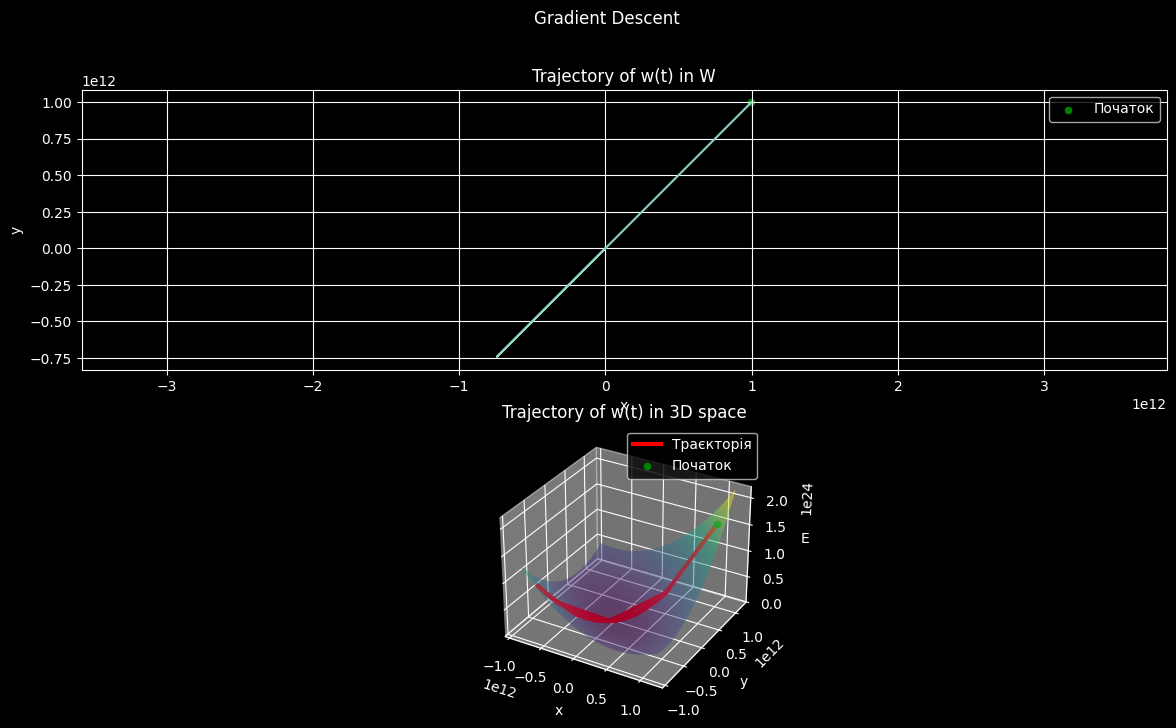

In [278]:
plot_descent(div_desc, E, 'Gradient Descent')

При $\eta = 10^{12}$ алгоритм не встиг збігтись за задану кількість максимальних кроків, однак за траекторією видно, що ваги не "вибухнули" і не стали збільшуватись до нескінченності, як це було у випадку з розбіжністю у звичайного градієнта, а залишались поблизу точки мінімуму (норма різниці дорівнює 1.23).

Можна зробити висновок, що Adam набагато менше залежить від значення кроку $\eta$, ніж звичайний градієнтний спуск